**This notebook addresses the class imbalance problem present in the dataset. To mitigate this, three resampling techniques are applied: SMOTE, Random Oversampling, and Random Undersampling. The goal is to determine which method best enhances the model's ability to correctly identify both classes.**

In [5]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 113.8 MB/s eta 0:00:00


In [6]:
# Import Nilearn library
from nilearn import datasets
import nilearn.datasets
from nilearn.datasets import fetch_oasis_vbm
from nilearn.image import load_img

In [7]:
# Import necessary libraries
from nilearn.datasets import fetch_oasis_vbm
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
from nilearn.maskers import NiftiMasker
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns
from sklearn.impute import SimpleImputer

**Pre-trained DenseNet+SVM with SMOTE**

In [8]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 22.9 MB/s eta 0:00:00


In [9]:
import random
import tensorflow as tf
import numpy as np
import os
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS']= '1'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [10]:
# Import libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import optuna
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

**Pre-Processing**

In [11]:
# Load the dataset
dataset = fetch_oasis_vbm(n_subjects=403)
images = dataset.gray_matter_maps
labels = np.where(dataset.ext_vars['cdr'].astype(float) > 0, 1, 0)  # 1: Demented, 0: Non-demented

[_add_readme_to_default_data_locations] Added README.md to /root/nilearn_data

[get_dataset_dir] Dataset created in /root/nilearn_data/oasis1

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/6364/archive_dartel.tgz ...

[_chunk_report_] Downloaded 18079744 of 905208634 bytes (2.0%%,   49.1s remaining)

[_chunk_report_] Downloaded 45662208 of 905208634 bytes (5.0%%,   37.7s remaining)

[_chunk_report_] Downloaded 73252864 of 905208634 bytes (8.1%%,   34.1s remaining)

[_chunk_report_] Downloaded 99459072 of 905208634 bytes (11.0%%,   32.4s remaining)

[_chunk_report_] Downloaded 127377408 of 905208634 bytes (14.1%%,   30.6s remaining)

[_chunk_report_] Downloaded 155410432 of 905208634 bytes (17.2%%,   29.0s remaining)

[_chunk_report_] Downloaded 183410688 of 905208634 bytes (20.3%%,   27.6s remaining)

[_chunk_report_] Downloaded 211271680 of 905208634 bytes (23.3%%,   26.3s remaining)

[_chunk_report_] Downloaded 239050752 of 905208634 bytes (26.4%%,   25.1s remaining)

[_chunk_report_] Downloaded 265666560 of 905208634 bytes (29.3%%,   24.1s remaining)

[_chunk_report_] Downloaded 293978112 of 905208634 bytes (32.5%%,   22.9s remaining)

[_chunk_report_] Downloaded 319406080 of 905208634 bytes (35.3%%,   22.1s remaining)

[_chunk_report_] Downloaded 346669056 of 905208634 bytes (38.3%%,   21.0s remaining)

[_chunk_report_] Downloaded 372350976 of 905208634 bytes (41.1%%,   20.1s remaining)

[_chunk_report_] Downloaded 400146432 of 905208634 bytes (44.2%%,   19.0s remaining)

[_chunk_report_] Downloaded 428187648 of 905208634 bytes (47.3%%,   17.9s remaining)

[_chunk_report_] Downloaded 454803456 of 905208634 bytes (50.2%%,   16.9s remaining)

[_chunk_report_] Downloaded 482197504 of 905208634 bytes (53.3%%,   15.8s remaining)

[_chunk_report_] Downloaded 509976576 of 905208634 bytes (56.3%%,   14.8s remaining)

[_chunk_report_] Downloaded 537247744 of 905208634 bytes (59.4%%,   13.7s remaining)

[_chunk_report_] Downloaded 563986432 of 905208634 bytes (62.3%%,   12.7s remaining)

[_chunk_report_] Downloaded 591765504 of 905208634 bytes (65.4%%,   11.7s remaining)

[_chunk_report_] Downloaded 614072320 of 905208634 bytes (67.8%%,   10.9s remaining)

[_chunk_report_] Downloaded 639754240 of 905208634 bytes (70.7%%,   10.0s remaining)

[_chunk_report_] Downloaded 667140096 of 905208634 bytes (73.7%%,    8.9s remaining)

[_chunk_report_] Downloaded 695451648 of 905208634 bytes (76.8%%,    7.9s remaining)

[_chunk_report_] Downloaded 722706432 of 905208634 bytes (79.8%%,    6.8s remaining)

[_chunk_report_] Downloaded 749445120 of 905208634 bytes (82.8%%,    5.8s remaining)

[_chunk_report_] Downloaded 774750208 of 905208634 bytes (85.6%%,    4.9s remaining)

[_chunk_report_] Downloaded 801095680 of 905208634 bytes (88.5%%,    3.9s remaining)

[_chunk_report_] Downloaded 828358656 of 905208634 bytes (91.5%%,    2.9s remaining)

[_chunk_report_] Downloaded 856276992 of 905208634 bytes (94.6%%,    1.8s remaining)

[_chunk_report_] Downloaded 883015680 of 905208634 bytes (97.5%%,    0.8s remaining)

[fetch_single_file]  ...done. (34 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/oasis1/83046f41ee203fabb5a08fb8484e9b69/archive_dartel.tgz...

[uncompress_file] .. done.

In [12]:
# Initial Split (before Standardization)
images_trainval, images_test, y_trainval, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

images_train, images_val, y_train, y_val = train_test_split(images_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval)

In [13]:
# Load images as flattened vectors
def load_flattened_images(image_paths):
    data = []
    for path in tqdm(image_paths):
        img = nib.load(path).get_fdata().astype(np.float32)
        data.append(img.flatten())
    return np.array(data)

X_train_flat = load_flattened_images(images_train)
X_val_flat = load_flattened_images(images_val)
X_test_flat = load_flattened_images(images_test)

# Perform Z-score normalization using StandardScaler
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_val_flat = scaler.transform(X_val_flat)
X_test_flat = scaler.transform(X_test_flat)


100%|██████████| 81/81 [00:01<00:00, 64.48it/s]


In [14]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE (only to training data)
oversample = SMOTE(random_state=42)
X_train_smote, y_train_smote = oversample.fit_resample(X_train_flat, y_train)

In [15]:
# Reshape back the images to 3D and build Torch Dataset
class OASISDataset(Dataset):
    def __init__(self, flat_data, labels, original_shape=(91, 109, 91)):
        self.flat_data = flat_data
        self.labels = labels
        self.original_shape = original_shape

    def __len__(self):
        return len(self.flat_data)

    def __getitem__(self, idx):
        img = self.flat_data[idx].reshape(self.original_shape)
        img_tensor = torch.tensor(img).unsqueeze(0)  # shape: (1, 91, 109, 91)
        return img_tensor, self.labels[idx]

train_dataset = OASISDataset(X_train_smote, y_train_smote)
val_dataset = OASISDataset(X_val_flat, y_val)
test_dataset = OASISDataset(X_test_flat, y_test)


In [ ]:
# The pre-trained BrainAge_DenseNet is retrived from Hugging Face https://huggingface.co/SisInfLab-AIBio/BrainAge_DenseNet
# Reference paper: De Bonis, M. L. N., Fasano, G., Lombardi, A., Ardito, C., Ferrara, A., Di Sciascio, E., & Di Noia, T. (2024). Explainable brain
# age prediction: a comparative evaluation of morphometric and deep learning pipelines. Brain Informatics, 11(1), 33.

In [ ]:
# The SVM hyperparamters are retrieved from this paper: Givian, H., Calbimonte, J. P., & for the Alzheimer’s Disease Neuroimaging Initiative (2024)
# Early diagnosis of Alzheimer’s disease and mild cognitive impairment using MRI analysis and machine learning algorithms. Discover Applied Sciences, 7(1), 27.

In [16]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/brainage_densenet')


Mounted at /content/drive


In [21]:
# Load Pre-trained BrainAge DenseNet and prepare the feature extractor
from densenet import load_preTrained_DenseNet
model_path = "/content/drive/MyDrive/brainage_densenet/DenseNet_params.pt"
full_model = load_preTrained_DenseNet(device=device, path=model_path).to(device)
full_model.eval()

for param in full_model.parameters():
    param.requires_grad = False

feature_extractor = torch.nn.Sequential(*list(full_model.children())[:-1]).to(device)

# Extract Features
def extract_features(model, dataset, batch_size=4):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    features = []
    model.eval()
    with torch.no_grad():
        for x, _ in tqdm(loader):
            x = x.to(device)
            out = model(x).view(x.size(0), -1)
            features.append(out.cpu().numpy())
    return np.vstack(features)

X_train = extract_features(feature_extractor, train_dataset)
X_val = extract_features(feature_extractor, val_dataset)
X_test = extract_features(feature_extractor, test_dataset)

100%|██████████| 21/21 [00:48<00:00,  2.29s/it]


In [22]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define the Optuna Objective function and the hyperparameters

def objective(trial):
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
    C = trial.suggest_categorical("C", [0.01, 0.1, 1, 10, 100, 1000])
    gamma = trial.suggest_categorical("gamma", [1e-4, 1e-3, 1e-2, 0.1, 1, 10])
    # Configure SVM based on kernel
    if kernel == "linear":
        model = SVC(C=C, kernel=kernel, probability=True)
    else:
        model = SVC(C=C, kernel=kernel, gamma=gamma, probability=True)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train_smote, cv=skf, scoring='accuracy')   # X_train: DenseNet features extracted from X_train_smote; y_train_smote: labels from SMOTE
    return scores.mean()


In [23]:
import optuna
import logging

# Suppress Optuna INFO and DEBUG logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Run the optimization
study_densenetsvm = optuna.create_study(direction="maximize")
study_densenetsvm.optimize(objective, n_trials=30, n_jobs=1)
print("Best SVM Params:", study_densenetsvm.best_params)

Best SVM Params: {'kernel': 'linear', 'C': 10, 'gamma': 10}


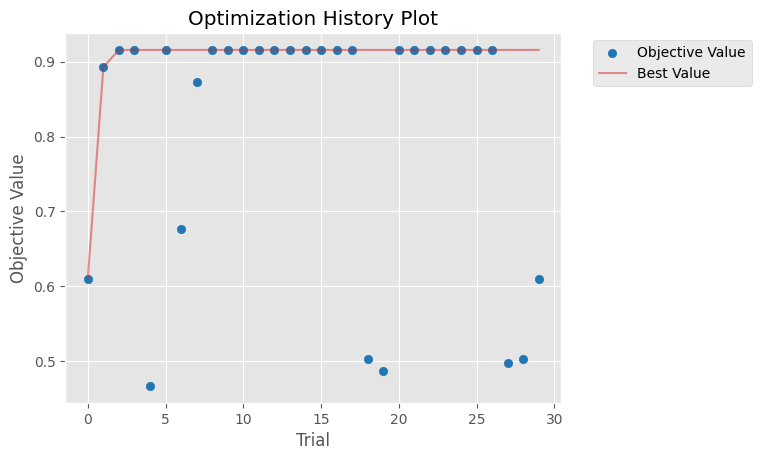

In [24]:
import warnings
import optuna.visualization.matplotlib as vis_matplotlib

# Suppress warning and plot the optimization history
with warnings.catch_warnings():
    warnings.simplefilter("ignore", optuna.exceptions.ExperimentalWarning)
    ax = vis_matplotlib.plot_optimization_history(study_densenetsvm)

# Save the figure
fig = ax.figure
fig.savefig("optuna_optimization_history_densenetsvmSMOTE.png", dpi=300, bbox_inches='tight')


In [25]:
smotedensenetsvm_params = study_densenetsvm.best_params
print(smotedensenetsvm_params)

{'kernel': 'linear', 'C': 10, 'gamma': 10}


In [26]:
final_params_smotedensenetsvm = dict(kernel=smotedensenetsvm_params['kernel'], C= smotedensenetsvm_params['C'], gamma = smotedensenetsvm_params['gamma'])

In [27]:
# Combine train and val sets
X_trainval_final = np.concatenate([X_train, X_val], axis=0)
y_trainval_final = np.concatenate([y_train_smote, y_val], axis=0)

# Define and train the final SVM model using the best hyperparameters
model = SVC(kernel='linear', C=10, gamma=10, probability=True)

# Train the algorithm on combined train+val set
model.fit(X_trainval_final, y_trainval_final)


SVC(C=10, gamma=10, kernel='linear', probability=True)

In [30]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, precision_score,
                             recall_score, f1_score, log_loss, brier_score_loss,
                             roc_auc_score, classification_report, confusion_matrix,
                             roc_curve, auc)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the evaluation function
def evaluate_model(y_true, y_pred, y_proba, class_names=None, save_path=None):
    if class_names is None:
        class_names = ['Non-Demented', 'Demented']

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)
    if y_proba.ndim > 1:
        y_proba = y_proba[:, 1]

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    logloss = log_loss(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)

    # Print metrics
    print(f"Accuracy:             {accuracy:.4f}")
    print(f"Balanced Accuracy:    {balanced_acc:.4f}")
    print(f"Precision:            {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1 Score:             {f1:.4f}")
    print(f"Log Loss:             {logloss:.4f}")
    print(f"Brier Score:          {brier:.4f}")
    print(f"AUC-ROC:              {roc_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

FINAL SVM MODEL EVALUATION ON TEST SET
Accuracy:             0.7654
Balanced Accuracy:    0.7008
Precision:            0.5000
Recall (Sensitivity): 0.5789
F1 Score:             0.5366
Log Loss:             0.7090
Brier Score:          0.1715
AUC-ROC:              0.7419

Classification Report:
              precision    recall  f1-score   support

Non-Demented       0.86      0.82      0.84        62
    Demented       0.50      0.58      0.54        19

    accuracy                           0.77        81
   macro avg       0.68      0.70      0.69        81
weighted avg       0.78      0.77      0.77        81



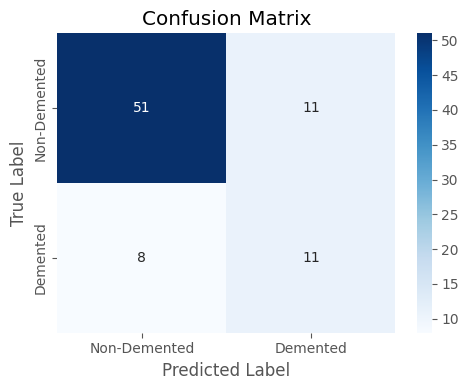

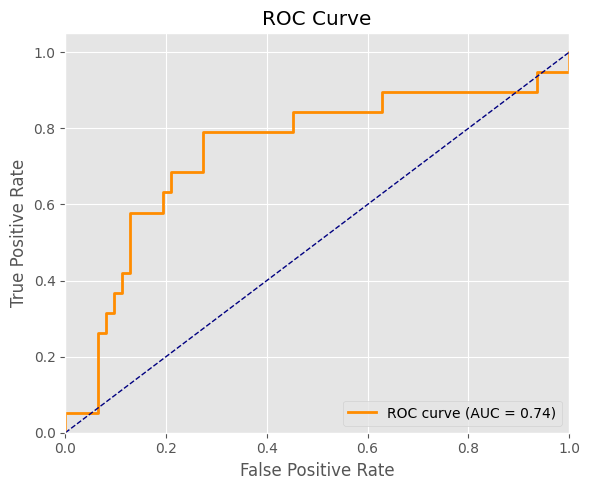

In [31]:
# Predict on the test set
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (Demented)

# Print header
print("FINAL SVM MODEL EVALUATION ON TEST SET")

# Evaluate and visualize
evaluate_model(y_true=y_test, y_pred=y_test_pred, y_proba=y_test_proba, class_names=['Non-Demented', 'Demented'])

# Save the confusion matrix
plt.savefig("SMOTEconfusion_matrix_svm_default_threshold.png", dpi=300)
plt.close()



EVALUATION WITH OPTIMAL THRESHOLD (0.2516)
Accuracy:             0.7407
Balanced Accuracy:    0.7576
Precision:            0.4688
Recall (Sensitivity): 0.7895
F1 Score:             0.5882
Log Loss:             0.7090
Brier Score:          0.1715
AUC-ROC:              0.7419

Classification Report:
              precision    recall  f1-score   support

Non-Demented       0.92      0.73      0.81        62
    Demented       0.47      0.79      0.59        19

    accuracy                           0.74        81
   macro avg       0.69      0.76      0.70        81
weighted avg       0.81      0.74      0.76        81



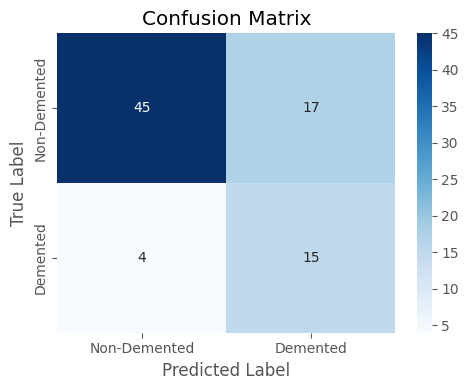

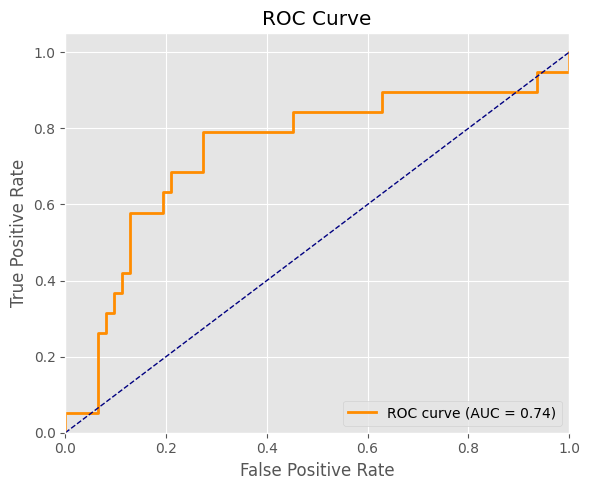

In [33]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Predict probabilities on test set
y_test_proba = model.predict_proba(X_test)[:, 1]

# Compute the optimal threshold based on F1 score
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_proba)
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nEVALUATION WITH OPTIMAL THRESHOLD ({optimal_threshold:.4f})")

# Apply optimal threshold to convert probabilities into binary predictions
y_test_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)

# Evaluate model performance at optimal threshold
evaluate_model(y_true=y_test, y_pred=y_test_pred_optimal, y_proba=y_test_proba, class_names=['Non-Demented', 'Demented'])

# Save the confusion matrix with optimal threshold
plt.savefig("SMOTEconfusion_matrix_svm_optimal_threshold.png", dpi=300)
plt.close()

**DenseNet+SVM with Oversampling**

In [ ]:
import random
import tensorflow as tf
import numpy as np
import os
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS']= '1'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [ ]:
# Import Imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import imblearn

In [ ]:
# Initial Split (before Standardization)
images_trainval, images_test, y_trainval, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

images_train, images_val, y_train, y_val = train_test_split(images_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval)

In [ ]:
# Load Images as flattened vectors
def load_flattened_images(image_paths):
    data = []
    for path in tqdm(image_paths):
        img = nib.load(path).get_fdata().astype(np.float32)
        data.append(img.flatten())
    return np.array(data)

X_train_flat = load_flattened_images(images_train)
X_val_flat = load_flattened_images(images_val)
X_test_flat = load_flattened_images(images_test)

# Perform Z-score normalization using StandardScaler
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_val_flat = scaler.transform(X_val_flat)
X_test_flat = scaler.transform(X_test_flat)

100%|██████████| 81/81 [00:01<00:00, 53.08it/s]


In [ ]:
# Apply Random Oversampling to the minority class on the training set
oversample = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_train_over, y_train_over = oversample.fit_resample(X_train_flat, y_train)

In [ ]:
# Reshape back the images to 3D and build Torch Dataset
class OASISDataset(Dataset):
    def __init__(self, flat_data, labels, original_shape=(91, 109, 91)):
        self.flat_data = flat_data
        self.labels = labels
        self.original_shape = original_shape

    def __len__(self):
        return len(self.flat_data)

    def __getitem__(self, idx):
        img = self.flat_data[idx].reshape(self.original_shape)
        img_tensor = torch.tensor(img).unsqueeze(0)  # shape: (1, 91, 109, 91)
        return img_tensor, self.labels[idx]

# Use Random Oversampled training data
train_dataset = OASISDataset(X_train_over, y_train_over)

# Validation and test sets remain unchanged
val_dataset = OASISDataset(X_val_flat, y_val)
test_dataset = OASISDataset(X_test_flat, y_test)

In [ ]:
# Load Pre-trained BrainAge DenseNet and prepare the feature extractor
from densenet import load_preTrained_DenseNet
model_path = "/content/drive/MyDrive/brainage_densenet/DenseNet_params.pt"
full_model = load_preTrained_DenseNet(device=device, path=model_path).to(device)
full_model.eval()

for param in full_model.parameters():
    param.requires_grad = False

feature_extractor = torch.nn.Sequential(*list(full_model.children())[:-1]).to(device)

# Extract Features
def extract_features(model, dataset, batch_size=4):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    features = []
    model.eval()
    with torch.no_grad():
        for x, _ in tqdm(loader):
            x = x.to(device)
            out = model(x).view(x.size(0), -1)
            features.append(out.cpu().numpy())
    return np.vstack(features)

X_train = extract_features(feature_extractor, train_dataset)
X_val = extract_features(feature_extractor, val_dataset)
X_test = extract_features(feature_extractor, test_dataset)

100%|██████████| 21/21 [00:01<00:00, 12.87it/s]


In [ ]:
from sklearn.utils import class_weight

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_over), y=y_train_over)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define the Optuna Objective function and the hyperparameters

def objective(trial):
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
    C = trial.suggest_categorical("C", [0.01, 0.1, 1, 10, 100, 1000])
    gamma = trial.suggest_categorical("gamma", [1e-4, 1e-3, 1e-2, 0.1, 1, 10])
    # Configure SVM based on kernel
    if kernel == "linear":
        model = SVC(C=C, kernel=kernel, probability=True)
    else:
        model = SVC(C=C, kernel=kernel, gamma=gamma, probability=True, class_weight=class_weights_dict)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train_over, cv=skf, scoring='accuracy')   # X_train: DenseNet features extracted from X_train_over; y_train_over: labels from RandomOverSampler
    return scores.mean()

In [ ]:
import optuna
import logging

# Suppress Optuna INFO and DEBUG logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Run the optimization
study_densenetsvm_over = optuna.create_study(direction="maximize")
study_densenetsvm_over.optimize(objective, n_trials=30, n_jobs=1)
print("Best SVM Params:", study_densenetsvm_over.best_params)

Best SVM Params: {'kernel': 'rbf', 'C': 100, 'gamma': 10}


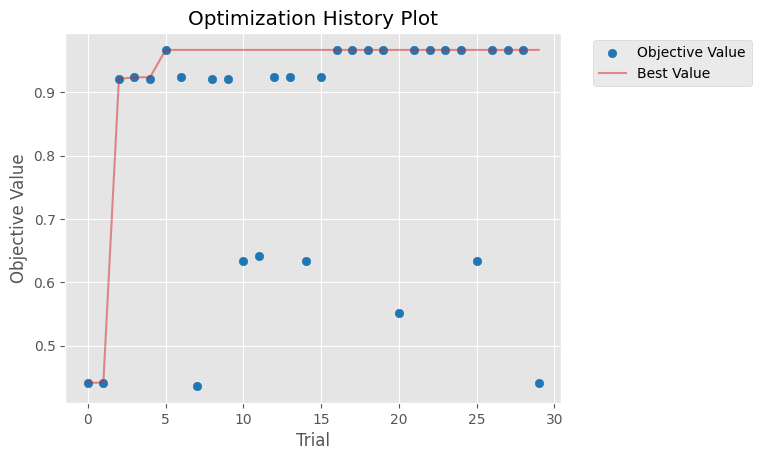

In [ ]:
import warnings
import optuna.visualization.matplotlib as vis_matplotlib

# Suppress warning and plot the optimization history
with warnings.catch_warnings():
    warnings.simplefilter("ignore", optuna.exceptions.ExperimentalWarning)
    ax = vis_matplotlib.plot_optimization_history(study_densenetsvm_over)

# Save the figure
fig = ax.figure
fig.savefig("optuna_optimization_history_densenetsvmOVER.png", dpi=300, bbox_inches='tight')

In [ ]:
over_densenetsvm_params = study_densenetsvm_over.best_params
print(over_densenetsvm_params)

{'kernel': 'rbf', 'C': 100, 'gamma': 10}


In [ ]:
final_params_over_densenetsvm = dict(kernel=over_densenetsvm_params['kernel'], C= over_densenetsvm_params['C'], gamma = over_densenetsvm_params['gamma'])

In [ ]:
from sklearn.utils import class_weight

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_over), y=y_train_over)
class_weights_dict = dict(enumerate(class_weights))


In [ ]:
# Combine train and val sets
X_trainval_final = np.concatenate([X_train, X_val], axis=0)
y_trainval_final = np.concatenate([y_train_over, y_val], axis=0)

# Define the final SVM model using the best hyperparameters
model = SVC(kernel='rbf', C=100, gamma=10, probability=True, class_weight=class_weights_dict)

# Train the algorithm on combined train+val set
model.fit(X_trainval_final, y_trainval_final)


SVC(C=100, class_weight={0: np.float64(1.0), 1: np.float64(1.0)}, gamma=10,
    probability=True)

In [ ]:
def evaluate_model(y_true, y_pred, y_proba, class_names=None, save_path=None):
    if class_names is None:
        class_names = ['Non-Demented', 'Demented']

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)
    if y_proba.ndim > 1:
        y_proba = y_proba[:, 1]

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    logloss = log_loss(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)

    # Print metrics
    print(f"Accuracy:             {accuracy:.4f}")
    print(f"Balanced Accuracy:    {balanced_acc:.4f}")
    print(f"Precision:            {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1 Score:             {f1:.4f}")
    print(f"Log Loss:             {logloss:.4f}")
    print(f"Brier Score:          {brier:.4f}")
    print(f"AUC-ROC:              {roc_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()



FINAL SVM MODEL EVALUATION ON TEST SET
Accuracy:             0.7654
Balanced Accuracy:    0.5000
Precision:            0.0000
Recall (Sensitivity): 0.0000
F1 Score:             0.0000
Log Loss:             0.6611
Brier Score:          0.2041
AUC-ROC:              0.5000

Classification Report:
              precision    recall  f1-score   support

Non-Demented       0.77      1.00      0.87        62
    Demented       0.00      0.00      0.00        19

    accuracy                           0.77        81
   macro avg       0.38      0.50      0.43        81
weighted avg       0.59      0.77      0.66        81



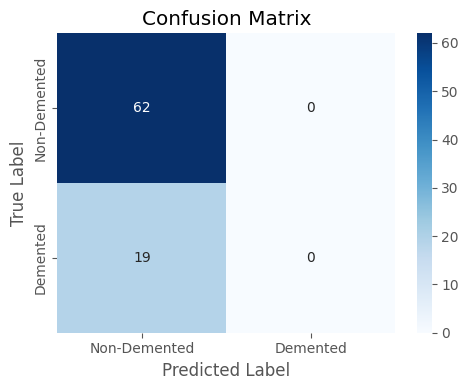

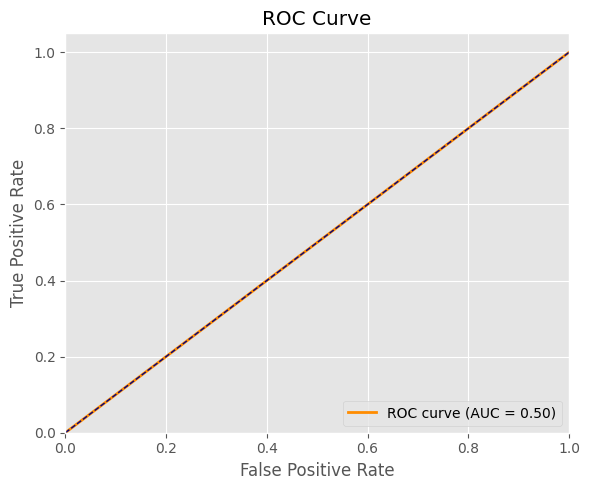

In [ ]:
# Predict on the test set
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (Demented)

# Print header
print("FINAL SVM MODEL EVALUATION ON TEST SET")

# Evaluate model's performance
evaluate_model(y_true=y_test, y_pred=y_test_pred, y_proba=y_test_proba, class_names=['Non-Demented', 'Demented'])

# Save the confusion matrix
plt.savefig("OVERconfusion_matrix_svm_default_threshold.png", dpi=300)
plt.close()


# The results from the oversampled model indicate that it fails to correctly identify any cases from the Demented class, resulting in a recall, precision, and F1-score of 0.
# Despite achieving an overall accuracy of 76.54%, this is misleading due to class imbalance, as the model only predicts the majority (Non-Demented) class.
# The balanced accuracy and AUC-ROC of 0.5 confirm that the model performs no better than random guessing for distinguishing between the two classes.
# This suggests that RandomOverSampler method is insufficient to improve sensitivity toward the minority class.



EVALUATION WITH OPTIMAL THRESHOLD (0.0777)

FINAL SVM MODEL EVALUATION ON TEST SET
Accuracy:             0.2346
Balanced Accuracy:    0.5000
Precision:            0.2346
Recall (Sensitivity): 1.0000
F1 Score:             0.3800
Log Loss:             0.6611
Brier Score:          0.2041
AUC-ROC:              0.5000

Classification Report:
              precision    recall  f1-score   support

Non-Demented       0.00      0.00      0.00        62
    Demented       0.23      1.00      0.38        19

    accuracy                           0.23        81
   macro avg       0.12      0.50      0.19        81
weighted avg       0.06      0.23      0.09        81



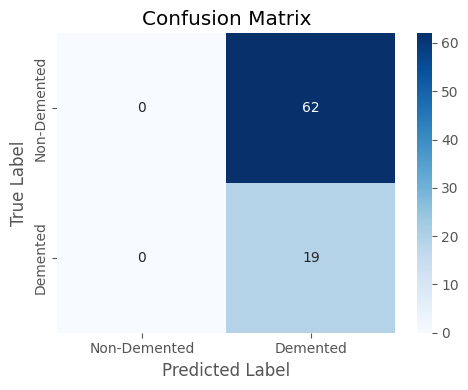

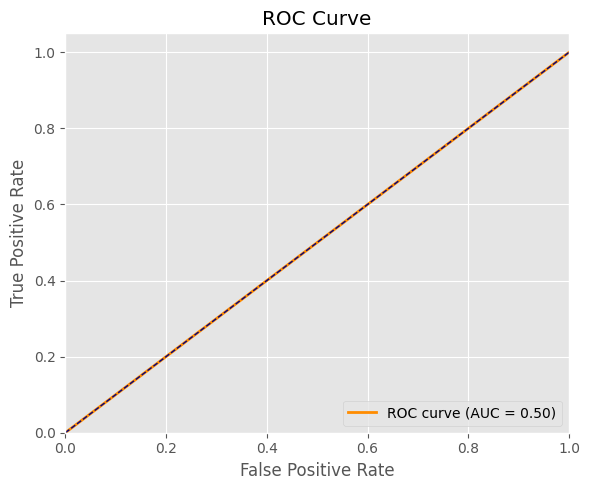

In [ ]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Predict probabilities on test set
y_test_proba = model.predict_proba(X_test)[:, 1]

# Compute the optimal threshold based on F1 score
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_proba)
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nEVALUATION WITH OPTIMAL THRESHOLD ({optimal_threshold:.4f})")

# Apply optimal threshold to convert probabilities into binary predictions
y_test_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)

# Evaluate model performance at optimal threshold
evaluate_model(y_true=y_test, y_pred=y_test_pred_optimal, y_proba=y_test_proba, class_names=['Non-Demented', 'Demented'])

# Save the confusion matrix with optimal threshold
plt.savefig("OVERconfusion_matrix_svm_optimal_threshold.png", dpi=300)
plt.close()


# These evaluation results show the performance of the SVM model when using an optimal threshold of 0.0777.
# The recall for the Demented class is perfect at 1.00, meaning the model successfully identified all true positive dementia cases.
# However, this came at the cost of precision (0.23) and overall accuracy (0.23), since the model classified nearly everything as Demented, resulting in many false positives.
# The balanced accuracy and AUC-ROC of 0.5 indicate that the model performs no better than random guessing in distinguishing between the classes.

**DenseNet+SVM with Undersampling**

In [ ]:
import random
import tensorflow as tf
import numpy as np
import os
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS']= '1'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [ ]:
# Initial Split (before Standardization)
images_trainval, images_test, y_trainval, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

images_train, images_val, y_train, y_val = train_test_split(images_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval)

In [ ]:
# Load Images as flattened vectors
def load_flattened_images(image_paths):
    data = []
    for path in tqdm(image_paths):
        img = nib.load(path).get_fdata().astype(np.float32)
        data.append(img.flatten())
    return np.array(data)

X_train_flat = load_flattened_images(images_train)
X_val_flat = load_flattened_images(images_val)
X_test_flat = load_flattened_images(images_test)

# Perform Z-score normalization using StandardScaler
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_val_flat = scaler.transform(X_val_flat)
X_test_flat = scaler.transform(X_test_flat)

100%|██████████| 81/81 [00:02<00:00, 32.86it/s]


In [ ]:
# Apply Random Undersampling to the majority class on the training set
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_train_under, y_train_under = undersample.fit_resample(X_train_flat, y_train)


In [ ]:
# Reshape back the images to 3D and build Torch Dataset
class OASISDataset(Dataset):
    def __init__(self, flat_data, labels, original_shape=(91, 109, 91)):
        self.flat_data = flat_data
        self.labels = labels
        self.original_shape = original_shape

    def __len__(self):
        return len(self.flat_data)

    def __getitem__(self, idx):
        img = self.flat_data[idx].reshape(self.original_shape)
        img_tensor = torch.tensor(img).unsqueeze(0)  # shape: (1, 91, 109, 91)
        return img_tensor, self.labels[idx]

# Use Random Undersampled training data for training dataset
train_dataset = OASISDataset(X_train_under, y_train_under)

# Validation and test sets remain unchanged
val_dataset = OASISDataset(X_val_flat, y_val)
test_dataset = OASISDataset(X_test_flat, y_test)

In [ ]:
# Load Pre-trained BrainAge DenseNet and prepare the feature extractor
from densenet import load_preTrained_DenseNet
model_path = "/content/drive/MyDrive/brainage_densenet/DenseNet_params.pt"
full_model = load_preTrained_DenseNet(device=device, path=model_path).to(device)
full_model.eval()

for param in full_model.parameters():
    param.requires_grad = False

feature_extractor = torch.nn.Sequential(*list(full_model.children())[:-1]).to(device)

# Extract Features
def extract_features(model, dataset, batch_size=4):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    features = []
    model.eval()
    with torch.no_grad():
        for x, _ in tqdm(loader):
            x = x.to(device)
            out = model(x).view(x.size(0), -1)
            features.append(out.cpu().numpy())
    return np.vstack(features)

X_train = extract_features(feature_extractor, train_dataset)
X_val = extract_features(feature_extractor, val_dataset)
X_test = extract_features(feature_extractor, test_dataset)

100%|██████████| 21/21 [01:08<00:00,  3.25s/it]


In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define the Optuna Objective function and the hyperparameters

def objective(trial):
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
    C = trial.suggest_categorical("C", [0.01, 0.1, 1, 10, 100, 1000])
    gamma = trial.suggest_categorical("gamma", [1e-4, 1e-3, 1e-2, 0.1, 1, 10])
    # Configure SVM based on kernel
    if kernel == "linear":
        model = SVC(C=C, kernel=kernel, probability=True)
    else:
        model = SVC(C=C, kernel=kernel, gamma=gamma, probability=True)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train_under, cv=skf, scoring='accuracy')   # X_train: DenseNet features extracted from X_train_under; y_train_under: labels from RandomUnderSampler
    return scores.mean()

In [ ]:
import optuna
import logging

# Suppress Optuna INFO and DEBUG logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Run the optimization
study_densenetsvm_under = optuna.create_study(direction="maximize")
study_densenetsvm_under.optimize(objective, n_trials=30, n_jobs=1)
print("Best SVM Params:", study_densenetsvm_under.best_params)

Best SVM Params: {'kernel': 'poly', 'C': 0.01, 'gamma': 0.001}


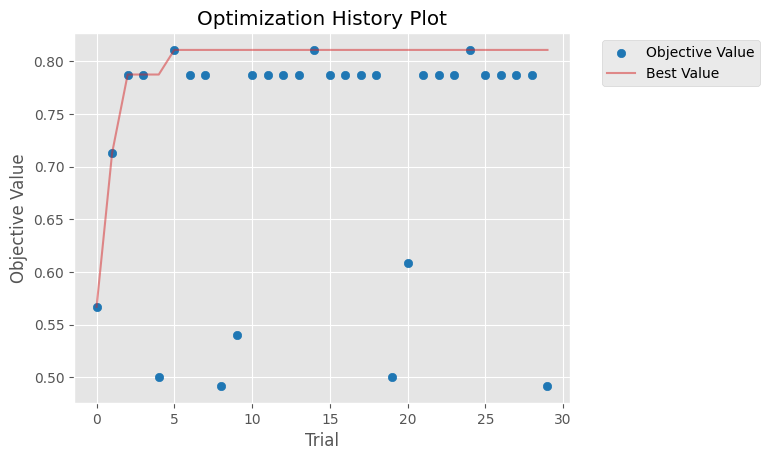

In [ ]:
import warnings
import optuna.visualization.matplotlib as vis_matplotlib

# Suppress warning and plot the optimization history
with warnings.catch_warnings():
    warnings.simplefilter("ignore", optuna.exceptions.ExperimentalWarning)
    ax = vis_matplotlib.plot_optimization_history(study_densenetsvm_under)

# Save the figure
fig = ax.figure
fig.savefig("optuna_optimization_history_densenetsvmUNDER.png", dpi=300, bbox_inches='tight')

In [ ]:
under_densenetsvm_params = study_densenetsvm_under.best_params
print(under_densenetsvm_params)

{'kernel': 'poly', 'C': 0.01, 'gamma': 0.001}


In [ ]:
final_params_under_densenetsvm = dict(kernel=under_densenetsvm_params['kernel'], C= under_densenetsvm_params['C'], gamma = under_densenetsvm_params['gamma'])

In [ ]:
# Combine train and val sets
X_trainval_final = np.concatenate([X_train, X_val], axis=0)
y_trainval_final = np.concatenate([y_train_under, y_val], axis=0)

# Define the final SVM model using the best hyperparameters
model = SVC(kernel='poly', C=0.01, gamma=0.001, probability=True)

# Train the algorithm on combined train+val set
model.fit(X_trainval_final, y_trainval_final)


SVC(C=0.01, gamma=0.001, kernel='poly', probability=True)

In [ ]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, precision_score,
                             recall_score, f1_score, log_loss, brier_score_loss,
                             roc_auc_score, classification_report, confusion_matrix,
                             roc_curve, auc)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the evaluation function
def evaluate_model(y_true, y_pred, y_proba, class_names=None, save_path=None):
    if class_names is None:
        class_names = ['Non-Demented', 'Demented']

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)
    if y_proba.ndim > 1:
        y_proba = y_proba[:, 1]

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    logloss = log_loss(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)

    # Print metrics
    print(f"Accuracy:             {accuracy:.4f}")
    print(f"Balanced Accuracy:    {balanced_acc:.4f}")
    print(f"Precision:            {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1 Score:             {f1:.4f}")
    print(f"Log Loss:             {logloss:.4f}")
    print(f"Brier Score:          {brier:.4f}")
    print(f"AUC-ROC:              {roc_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

FINAL SVM MODEL EVALUATION ON TEST SET
Accuracy:             0.7901
Balanced Accuracy:    0.7716
Precision:            0.5385
Recall (Sensitivity): 0.7368
F1 Score:             0.6222
Log Loss:             0.7423
Brier Score:          0.1958
AUC-ROC:              0.8014

Classification Report:
              precision    recall  f1-score   support

Non-Demented       0.91      0.81      0.85        62
    Demented       0.54      0.74      0.62        19

    accuracy                           0.79        81
   macro avg       0.72      0.77      0.74        81
weighted avg       0.82      0.79      0.80        81



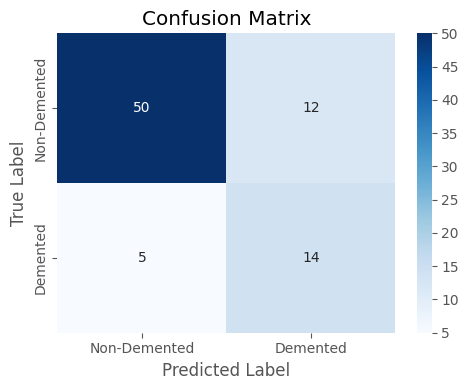

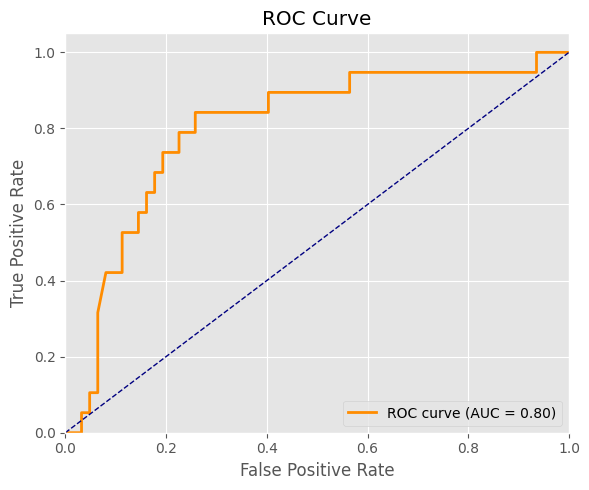

In [ ]:
# Predict on the test set
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (Demented)

# Print header
print("FINAL SVM MODEL EVALUATION ON TEST SET")

# Evaluate and visualize
evaluate_model(y_true=y_test, y_pred=y_test_pred, y_proba=y_test_proba, class_names=['Non-Demented', 'Demented'])

# Save the confusion matrix
plt.savefig("UNDERconfusion_matrix_svm_default_threshold.png", dpi=300)
plt.close()


EVALUATION WITH OPTIMAL THRESHOLD (0.3961)
Accuracy:             0.7654
Balanced Accuracy:    0.7920
Precision:            0.5000
Recall (Sensitivity): 0.8421
F1 Score:             0.6275
Log Loss:             0.7423
Brier Score:          0.1958
AUC-ROC:              0.8014

Classification Report:
              precision    recall  f1-score   support

Non-Demented       0.94      0.74      0.83        62
    Demented       0.50      0.84      0.63        19

    accuracy                           0.77        81
   macro avg       0.72      0.79      0.73        81
weighted avg       0.84      0.77      0.78        81



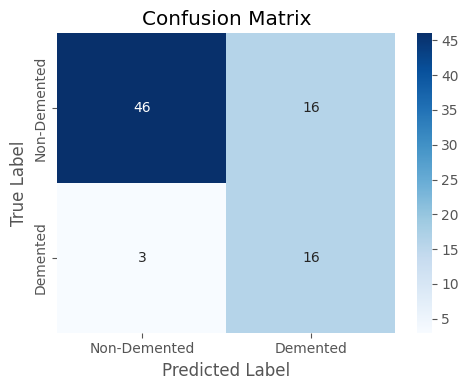

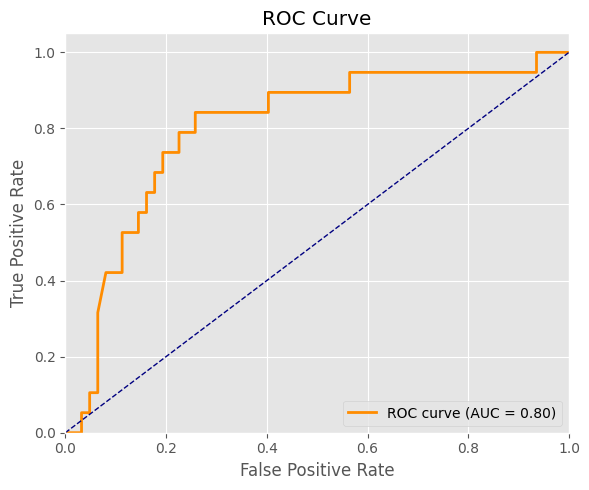

In [ ]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Predict probabilities on test set
y_test_proba = model.predict_proba(X_test)[:, 1]

# Compute the optimal threshold based on F1 score
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_proba)
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nEVALUATION WITH OPTIMAL THRESHOLD ({optimal_threshold:.4f})")

# Apply optimal threshold to convert probabilities into binary predictions
y_test_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)

# Evaluate model performance at optimal threshold
evaluate_model(y_true=y_test, y_pred=y_test_pred_optimal, y_proba=y_test_proba, class_names=['Non-Demented', 'Demented'])

# Save the confusion matrix with optimal threshold
plt.savefig("UNDERconfusion_matrix_svm_optimal_threshold.png", dpi=300)
plt.close()

**Model comparison**

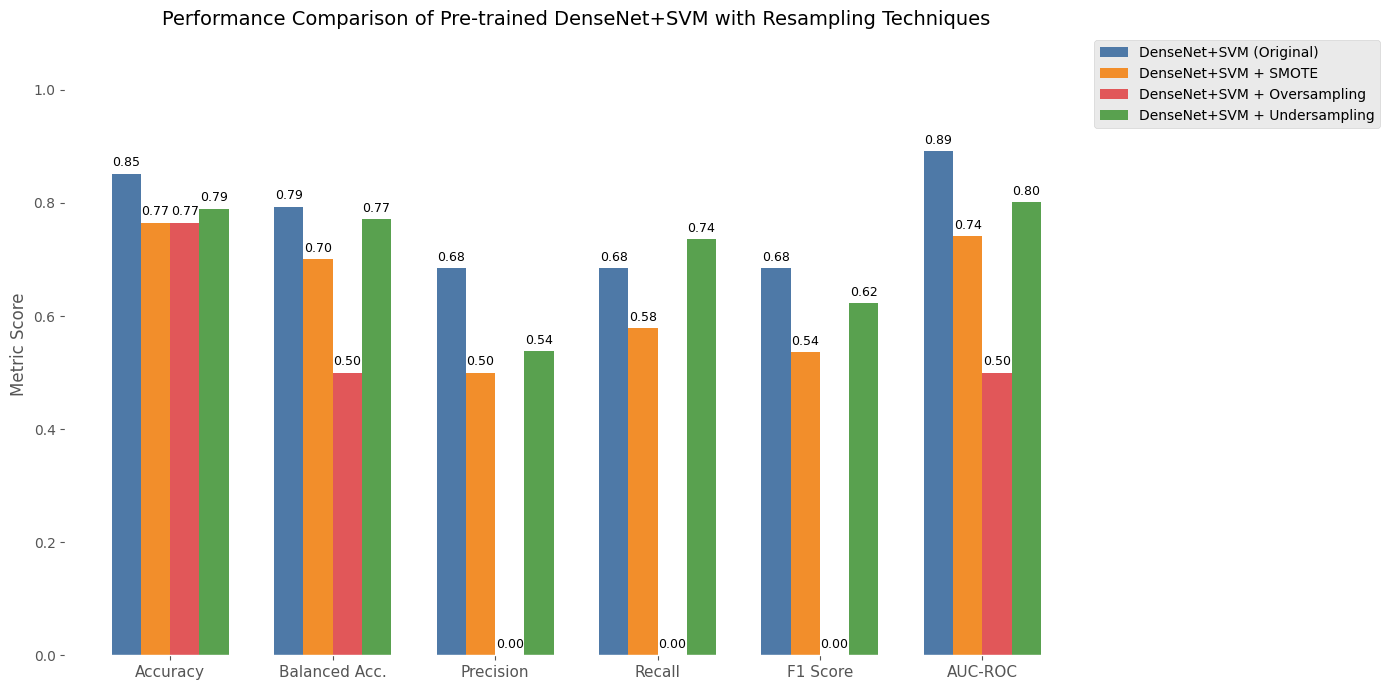

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Define clear model names
models = ['DenseNet+SVM (Original)', 'DenseNet+SVM + SMOTE', 'DenseNet+SVM + Oversampling', 'DenseNet+SVM + Undersampling']

# Define metrics for each model
accuracy = [0.8519, 0.7654, 0.7654, 0.7901]
balanced_accuracy = [0.7937, 0.7008, 0.5000, 0.7716]
precision = [0.6842, 0.5000, 0.0000, 0.5385]
recall = [0.6842, 0.5789, 0.0000, 0.7368]
f1 = [0.6842, 0.5366, 0.0000, 0.6222]
auc = [0.8913, 0.7419, 0.5000, 0.8014]

# Group metrics into array
metric_names = ['Accuracy', 'Balanced Acc.', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']
metrics = np.array([accuracy, balanced_accuracy, precision, recall, f1, auc])  # shape (6, 4)

# Plotting setup
x = np.arange(len(metric_names))
bar_width = 0.18
colors = ['#4E79A7', '#F28E2B', '#E15759', '#59A14F']

fig, ax = plt.subplots(figsize=(14, 7))
for i in range(len(models)):
    bars = ax.bar(x + i * bar_width, metrics[:, i], width=bar_width, label=models[i], color=colors[i])

    # Annotate values on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Define axes and layout
ax.set_ylabel('Metric Score')
ax.set_title('Performance Comparison of Pre-trained DenseNet+SVM with Resampling Techniques', fontsize=14)
ax.set_xticks(x + bar_width * 1.5)
ax.set_xticklabels(metric_names, fontsize=11)
ax.set_ylim(0, 1.1)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_facecolor('white')
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# Save the bar chart
plt.savefig("resampling_plot.png", dpi=300, bbox_inches='tight')
plt.close()
